In [1]:
import torch as T
import torch.nn as nn
from sklearn.feature_extraction import image
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from PIL import Image
from skimage import io
import torch.nn.functional as F

In [2]:
class CheatCode(nn.Module):
    def __init__(self, num_classes=2):
        super(CheatCode, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3),
           
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1000, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        return x

In [3]:
# load the trained model
#net = CheatCode()
net = T.load("trained_net")
net.to('cpu')
net.eval()

CheatCode(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU

In [4]:
def predictOneImage(path,img_name,size,number_patches,threshold):
    
    healthy_list = []
    fragmented_list = []
    
    # chargement de l'image
    img = io.imread(path+"/"+img_name)
    #extraction des patchs
    patches = image.extract_patches_2d(img, (size,size),max_patches=number_patches)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
    
    # pour chacun des patch
    for i in range(len(patches)):
        # on applique les mêmes transformations et conditions que pour les images du training
        patches[i] = patches[i].astype('uint16')
        m = np.mean(patches[i])
        if (m>threshold) :
            patch = Image.fromarray(patches[i])
            patch = patch.convert(mode='RGB')
            image_tensor = transform(patch)
            image_tensor = image_tensor.unsqueeze_(0)
            
            # on donne le patch à notre trained model
            output = net(image_tensor)
            
            # on récupère le maximum (0 ou 1 = bad ou good)
            _, predicted = T.max(output, 1)
            
            # on récupère le pourcentage de confiance dans la prédiction
            output = output[0].tolist()
            confidence = round(max(F.softmax(T.tensor([[output[0],output[1]]],dtype=T.float),dim=1).tolist()[0]),2)
            # si cette confiance est suffisante
            #print(confidence)
            # on ajoute dans l'une ou l'autre liste une valeur, et 1-cette valeur dans l'autre
            if predicted == 0:
                prediction = "fragmented"
                fragmented_list.append(confidence)
                healthy_list.append(1-confidence)
            else:
                prediction = "healthy"
                healthy_list.append(confidence)
                fragmented_list.append(1-confidence)
                    
        return healthy_list,fragmented_list
                    
 ### si on veut on peut afficher les résultats de chaque patch, ainsi que les moyennes de confiance
 ### mais c'est pas forcément très lisible quand on cherche à prédire de nombreuses images à la suite
    
            # print(f" image '{img_name}' patch n° {i} --> prediction: {prediction} (confidence = {confidence}%)")
    #total = frag_l+health_l
    #mean_confi_fr,mean_confi_health = 0,0
    #if frag_l > 0:
        #mean_confi_fr = round(sum(fragmented_list) / frag_l,2)
    #if health_l > 0:
        #mean_confi_health = round(sum(healthy_list) / health_l,2)
    #print(f"number of fragmented patch: {len(fragmented_list)}/{total} | mean fragmented confidence {mean_confi_fr}")
    #print(f"number of healthy patch: {len(healthy_list)}/{total} | mean healthy confidence {mean_confi_health}")
 
 ###                                                                                             ###
 ###                                                                                             ###

In [42]:
def predictOne_consistent(path,img_name,size,number_patches,threshold,repeats):
    
    # vu que les patchs sont piochés de manière aléatoire à chaque fois, 
    # j'ai trouvé qu'on obtenait des résultats plus fiables en faisant une moyenne
    # des prédictions sur plusieurs essais sur la même image
    healthy = []
    fragmented = []
    for i in range(repeats):
        healthy_list, fragmented_list = predictOneImage(path,img_name,size,number_patches,threshold)
        healthy += healthy_list
        fragmented += fragmented_list
    
    # moyenne des confiances
    frag_l = sum(fragmented)/max(1,len(fragmented))
    health_l = sum(healthy)/max(1,len(healthy))
    frag_l *= 0.375
    
    if health_l == 0 and frag_l == 0 :
        print("No valid patches can be extracted !")
        return 2
    
    # création d'un histogramme
    x = np.array(["Healthy", "Fragmented"])
    y = np.array([health_l,frag_l])
    fig, ax = plt.subplots()
    barp = plt.bar(x,y, color=['green', 'red'])
    
    ### si on veut on peut afficher la confiance mais pas très représentatif finalement j'ai l'impression ###
    #bar_label = [f'mean confidence: {mean_confi_health}',f' mean confidence: {mean_confi_fr}']
    #for idx,rect in enumerate(barp):
        #height = rect.get_height()
        #ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
              #  bar_label[idx],
              #  ha='center', va='bottom', rotation=0)
    plt.show()
    # la prédiction finale entre les deux classes. Si on regarde simplement la classe dominante, on aura 
    # une proportion de fragmented bien trop élevée. Empiriquement j'ai trouvé qu'un facteur de 0.30 était pas
    # trop mal et donnait des résultats assez bons.
    
    # donc si il y a une proportion de patchs ayant été prédit healthy au moins aussi importante qu'un 1/3 
    # des patchs fragmented, l'image est considérée comme appartenant à un tissu sain.
    #if health_l > 0.30*frag_l:
    
    if health_l > frag_l:
        print("prediction : HEALTHY (%s)"%(health_l/(health_l+frag_l)))
        return 1
    print("prediction : FRAGMENTED (%s)" %(frag_l/(health_l+frag_l)))
    return 0

In [43]:
def predictMultiples(path,size,number_patches,threshold,repeats):
    
    total = []
    # pour chaque image du répertoire
    for img_name in listdir(path) :
        # on ouvre et affiche l'image
        im = Image.open(path+"/"+img_name)
        #im = im.resize((488,360), Image.NEAREST)
        #display(im)
        
        res = predictOne_consistent(path,img_name,size,number_patches,threshold,repeats)
        total.append(res)
        
        print("------------------------------------------------------------")
        print("============================================================")
        print("------------------------------------------------------------")
        
    healthy_mito = total.count(1)   
    frag_mito = total.count(0)
    errors =  total.count(2)

    print(f"il y a eu une prédiction de {healthy_mito} healthy et {frag_mito} fragmented sur {len(total)} images traitées")
    if(errors >0) :
        print("Il y a %s images intraitables" %(errors))

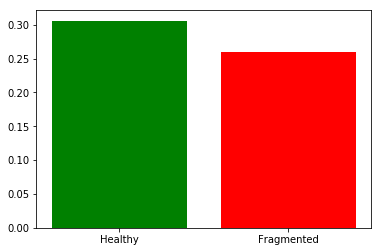

prediction : HEALTHY (0.5403973509933775)
------------------------------------------------------------
------------------------------------------------------------


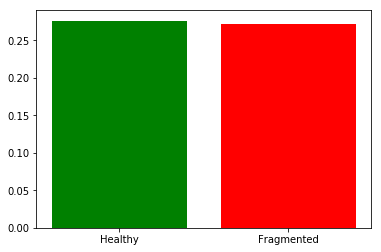

prediction : HEALTHY (0.5041095890410959)
------------------------------------------------------------
------------------------------------------------------------


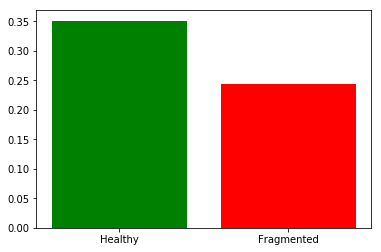

prediction : HEALTHY (0.5905362776025237)
------------------------------------------------------------
------------------------------------------------------------


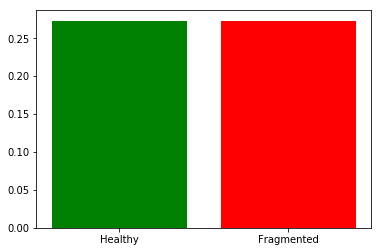

prediction : HEALTHY (0.5003436426116838)
------------------------------------------------------------
------------------------------------------------------------


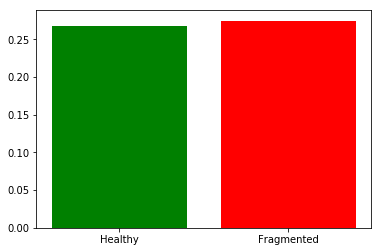

prediction : FRAGMENTED (0.5059907834101383)
------------------------------------------------------------
------------------------------------------------------------


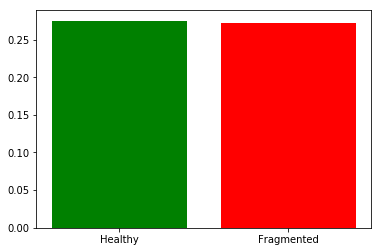

prediction : HEALTHY (0.5028571428571429)
------------------------------------------------------------
------------------------------------------------------------


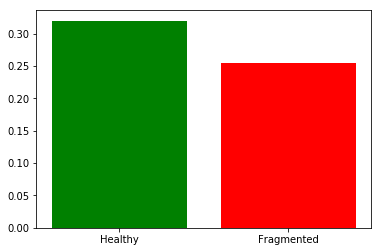

prediction : HEALTHY (0.5565217391304348)
------------------------------------------------------------
------------------------------------------------------------


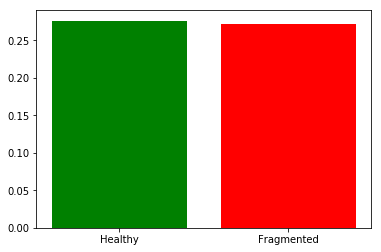

prediction : HEALTHY (0.5041095890410959)
------------------------------------------------------------
------------------------------------------------------------


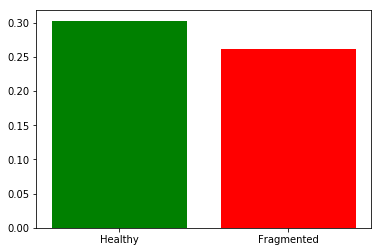

prediction : HEALTHY (0.53687707641196)
------------------------------------------------------------
------------------------------------------------------------


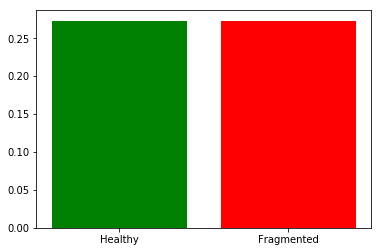

prediction : FRAGMENTED (0.5009174311926606)
------------------------------------------------------------
------------------------------------------------------------


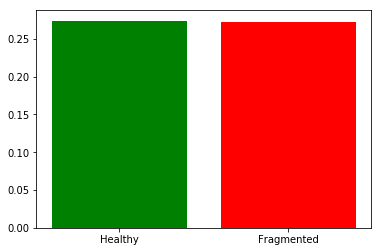

prediction : HEALTHY (0.5016018306636156)
------------------------------------------------------------
------------------------------------------------------------


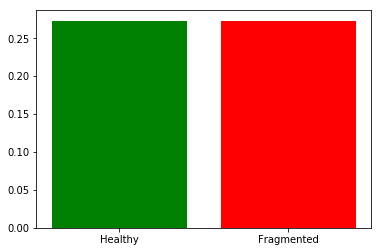

prediction : FRAGMENTED (0.5009174311926605)
------------------------------------------------------------
------------------------------------------------------------


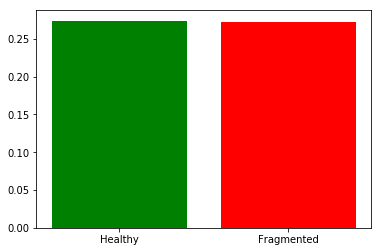

prediction : HEALTHY (0.5016018306636156)
------------------------------------------------------------
------------------------------------------------------------


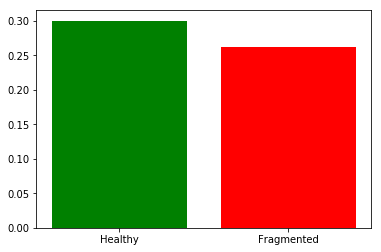

prediction : HEALTHY (0.5333333333333333)
------------------------------------------------------------
------------------------------------------------------------


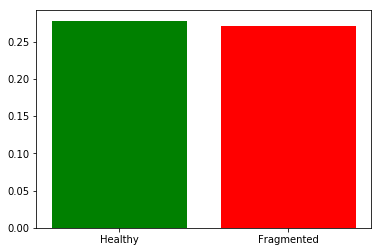

prediction : HEALTHY (0.5066059225512528)
------------------------------------------------------------
------------------------------------------------------------


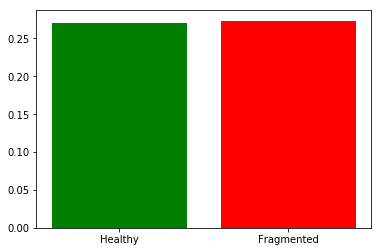

prediction : FRAGMENTED (0.5021814006888633)
------------------------------------------------------------
------------------------------------------------------------


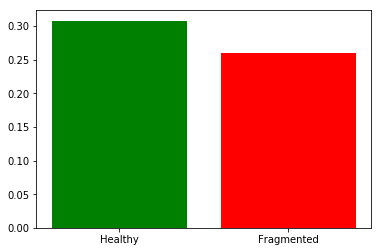

prediction : HEALTHY (0.5427312775330397)
------------------------------------------------------------
------------------------------------------------------------


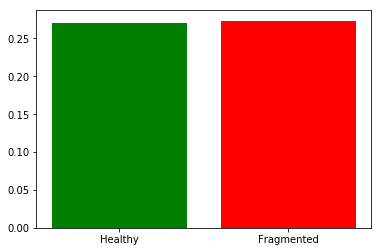

prediction : FRAGMENTED (0.5021814006888634)
------------------------------------------------------------
------------------------------------------------------------


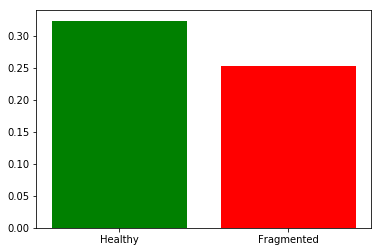

prediction : HEALTHY (0.5610389610389611)
------------------------------------------------------------
------------------------------------------------------------


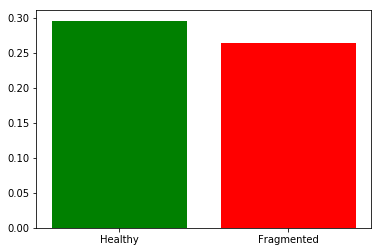

prediction : HEALTHY (0.5285714285714286)
------------------------------------------------------------
------------------------------------------------------------


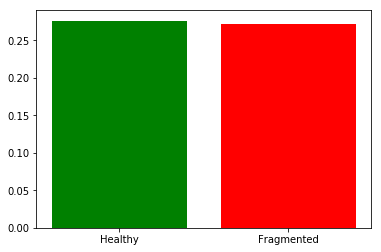

prediction : HEALTHY (0.5041095890410959)
------------------------------------------------------------
------------------------------------------------------------


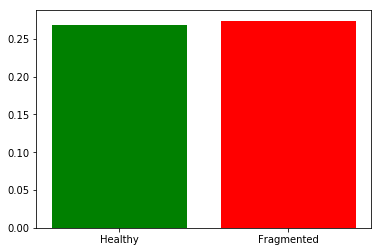

prediction : FRAGMENTED (0.5047180667433833)
------------------------------------------------------------
------------------------------------------------------------


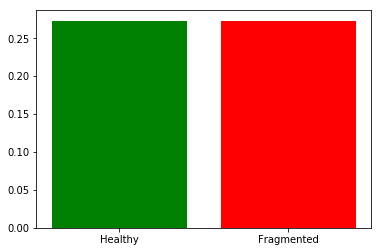

prediction : HEALTHY (0.5003436426116838)
------------------------------------------------------------
------------------------------------------------------------


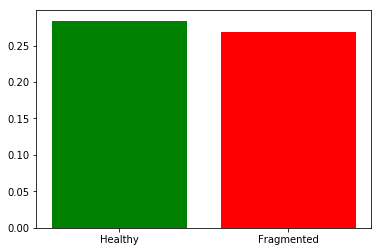

prediction : HEALTHY (0.5140271493212671)
------------------------------------------------------------
------------------------------------------------------------


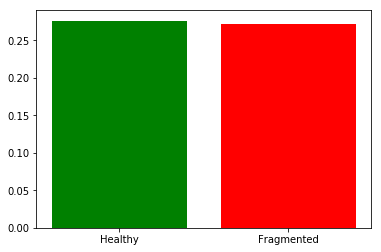

prediction : HEALTHY (0.5041095890410959)
------------------------------------------------------------
------------------------------------------------------------


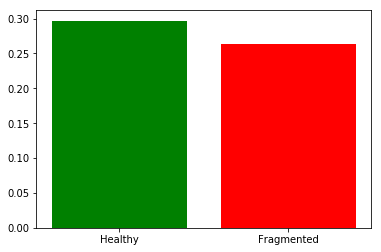

prediction : HEALTHY (0.5297658862876254)
------------------------------------------------------------
------------------------------------------------------------


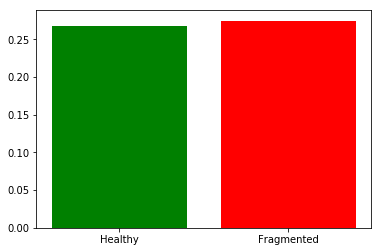

prediction : FRAGMENTED (0.5059907834101383)
------------------------------------------------------------
------------------------------------------------------------


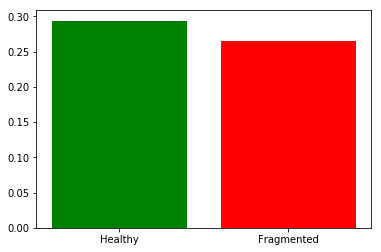

prediction : HEALTHY (0.5261744966442953)
------------------------------------------------------------
------------------------------------------------------------


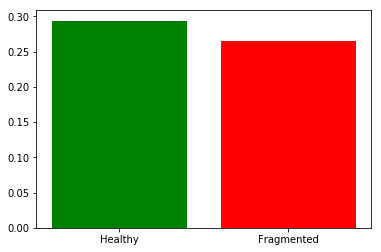

prediction : HEALTHY (0.5261744966442952)
------------------------------------------------------------
------------------------------------------------------------


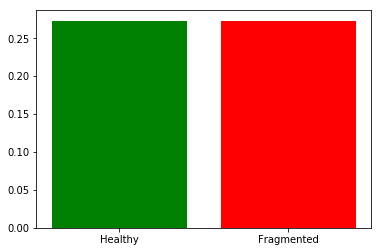

prediction : FRAGMENTED (0.5009174311926605)
------------------------------------------------------------
------------------------------------------------------------


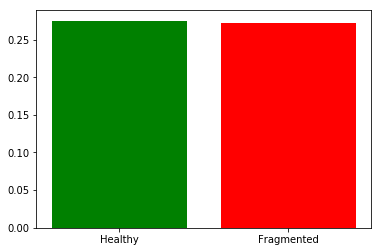

prediction : HEALTHY (0.502857142857143)
------------------------------------------------------------
------------------------------------------------------------


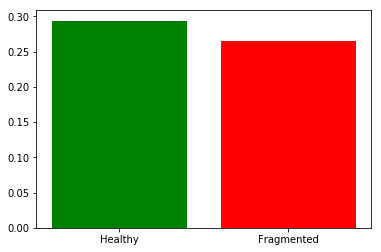

prediction : HEALTHY (0.5261744966442953)
------------------------------------------------------------
------------------------------------------------------------


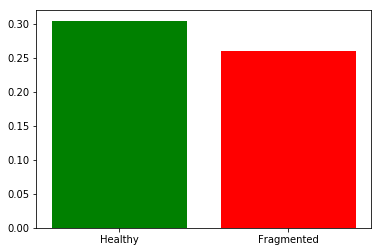

prediction : HEALTHY (0.5392265193370165)
------------------------------------------------------------
------------------------------------------------------------


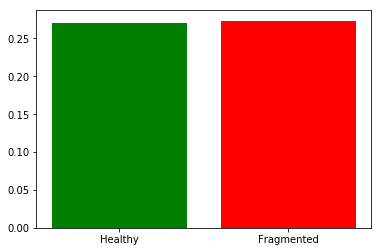

prediction : FRAGMENTED (0.5021814006888633)
------------------------------------------------------------
------------------------------------------------------------


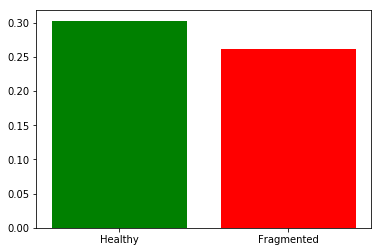

prediction : HEALTHY (0.5368770764119601)
------------------------------------------------------------
------------------------------------------------------------
il y a eu une prédiction de 26 healthy et 9 fragmented sur 35 images traitées


In [45]:
path = "./Data/Images-Cytation/Experiment2_201120/Bad"
size = 50
number_patches = 1000
threshold = 0
repeats = 10

predictMultiples(path,size,number_patches,threshold,repeats)